# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
### 構造推計（structural estimation）

In [2]:
using CSV # CSVファイルを読み込む際に必要
using DataFrames # CSVファイルを読み込む際に必要
using Dierckx # Spline & linear interpolation
using LinearAlgebra # 期待値計算
using Optim # 最適化
using Plots
#pyplot()

### カリブレーション
* パラメータをひとつの変数にまとめる：structを使う

In [3]:
include("GenerateGrid.jl")

Main.GenerateGrid

In [4]:
struct Params
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    r::Float64 #利子率

    η::Vector{Float64} #年齢・所得プロファイル
    ss::Float64 #公的年金

    surv::Vector{Float64} #生存確率

    nz::Int64 #所得リスクのグリッドサイズ
    tran::Matrix{Float64} #遷移確率行列
    endow::Vector{Float64} #所得リスクの実現値

    max_age::Int64 #最大年齢
    ret_age::Int64 #引退年齢

    # グリッド
    na::Int64 #貯蓄グリッドの数
    amax::Float64 #貯蓄グリッドの最大値
    amin::Float64 #貯蓄グリッドの最小値
    agrid::Vector{Float64} #貯蓄グリッド
end

In [5]:
# CSV形式でまとめたカリブレーションパラメータを読み込む
df = CSV.read("earnings_profiles.csv", DataFrame)
η = df[:, 2];

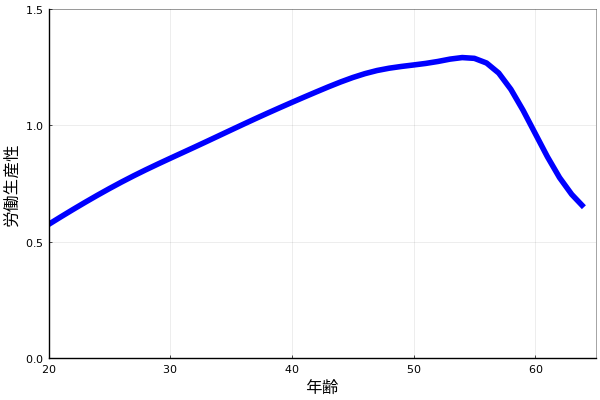

In [8]:
age = 20:64

plt = plot(age, η,
    color = :blue,
    legend = :none,
    xlabel = ("年齢"),
    ylabel = ("労働生産性"),
    xlims = (20, 65),
    ylims = (0, 1.5),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
# savefig(plt, "Fig3_labor_profile.eps")

In [10]:
# CSV形式でまとめたカリブレーションパラメータを読み込む
df = CSV.read("surv.csv", DataFrame)
surv = df[:, 2];

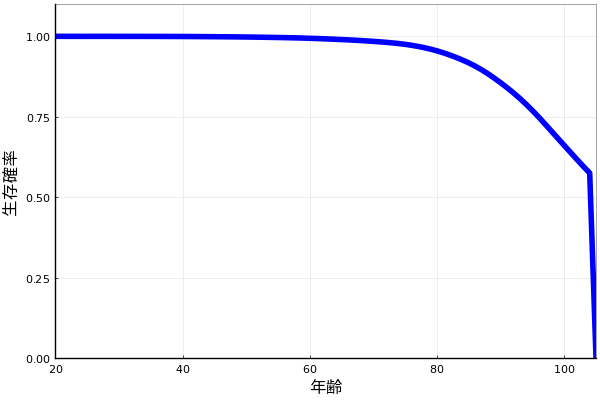

In [11]:
age = 20:105

plt = plot(age, surv,
    color = :blue,
    legend = :none,
    xlabel = ("年齢"),
    ylabel = ("生存確率"),
    xlims = (20, 105),
    ylims = (0, 1.1),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
#savefig(plt, "Fig3_survival_probability.eps")

In [12]:
function calibration()
    β = 0.98
    γ = 1.0
    r = 0.04

    # 労働所得プロファイル
    df = CSV.read("earnings_profiles.csv", DataFrame)
    η = df[:, 2]
    ss = 0.5 # 所得代替率でカリブレート

    # 生存確率
    df = CSV.read("surv.csv", DataFrame)
    surv = df[:, 2]

    nz = 3
    tran = [0.7451 0.2528 0.0021; 0.1360 0.7281 0.1360; 0.0021 0.2528 0.7451]
    endow = [0.8027, 1.0, 1.2457]
    
    max_age = 86 #20歳から105歳まで
    ret_age = 45 #20歳から64歳まで

    na = 101
    amax = 40.0
    amin = 0.0

    # 自作のコードで等分のグリッドを計算
    agrid = GenerateGrid.grid_uni(amin, amax, na)

    return Params(β, γ, r, η, ss, surv, nz, tran, endow, max_age, ret_age, na, amax, amin, agrid)
end

calibration (generic function with 1 method)

In [13]:
params = calibration();

---

## 経済学でよく使う関数

In [14]:
include("MyEconFcn.jl")

Main.MyEconFcn

---

## VFIのための準備
* 有限期間なので後ろ向きに解いていく

#### 現役期と引退期用の変数を設定
* 現役時代は資産$a$に加えて、労働生産性$z$と年齢$j$が状態変数になる
* 引退後は労働生産性が存在しなくなるので、$a$と$j$の2状態変数
* つまり、途中で変数のサイズが変わるので、それに対応した特別な変数を用意する
    * ⬇の書き方だと、x.yngは3状態変数、x.oldは2状態変数の変数
* 最大公約数的にずっと3状態変数で1期から86期までを定義しても計算上は全く問題ない
    * ただし、メモリの無駄使い
* x.oldの年齢のインデックスは1からスタートする点に注意

In [15]:
# 価値関数と政策関数用のstructを用意
mutable struct LifeCycleVariable
    yng::Array{Float64, 3} # worker: asset, endowment, age
    old::Array{Float64, 2} # retiree: asset, age
end

In [16]:
# value function
vfcn = LifeCycleVariable(
    zeros(params.na, params.nz, params.ret_age),
    zeros(params.na, params.max_age-params.ret_age)
);

In [17]:
# policy function
pfcn = LifeCycleVariable(
    zeros(params.na, params.nz, params.ret_age),
    zeros(params.na, params.max_age-params.ret_age)
);

---

## 引退期の価値関数

#### 最終期の価値関数

In [18]:
ret_period = params.max_age - params.ret_age

# 最終期はすべての資源を使い切る
for i = 1:params.na
    vfcn.old[i, ret_period] = MyEconFcn.crra((1+params.r)*params.agrid[i] + params.ss, params.γ)
    pfcn.old[i, ret_period] = 0.0
end

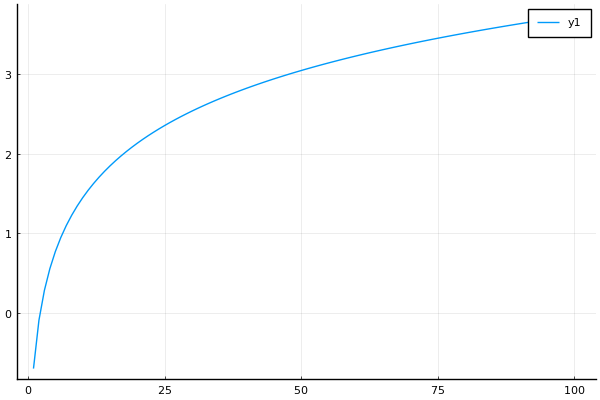

In [19]:
plot(vfcn.old[:, ret_period])

In [20]:
vnext = Spline1D(params.agrid, vfcn.old[:, ret_period], k=3, bc="extrapolate") #スプライン補間

Spline1D(knots=[0.0,0.8 … 39.2,40.0] (99 elements), k=3, extrapolation="extrapolate", residual=0.0)

In [21]:
"""
引退期のベルマン方程式

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`i::Int64`: 今期の貯蓄(値ではなくインデックスである点に注意)
`age::Int64`: 現在の年齢
`aprime::Float64`: 次期に残す貯蓄額
`vnext::Spline1D`: 次期の価値関数をスプライン近似した際の係数

### Outputs 
`value::Float64`:　負値にしたベルマン方程式
"""
function bellman_eq_retired(params::Params, i::Int64, age::Int64, aprime::Float64, vnext::Spline1D)
    wealth = (1+params.r)*params.agrid[i] + params.ss
    cons = wealth - aprime
    util = MyEconFcn.crra(cons, params.γ)
    vnext = params.surv[age]*params.β*vnext(aprime)
    value = util + vnext
    value = -1*value
    return value 
end

bellman_eq_retired

In [22]:
# 価値関数を繰り返し計算
for age = params.max_age-1:-1:params.ret_age+1

    # モデル上は20歳〜105歳だけど、引退直後(65歳)のindexは1なので注意
    age_ind = age - params.ret_age

    # 次期の価値関数を補間
    vnext = Spline1D(params.agrid, vfcn.old[:, age_ind+1], k=3, bc="extrapolate") #スプライン補間

    # 各資産の状態に応じて最適な貯蓄を探す
    for i = 1:params.na
        bellman_eq_retired!(aprime) = bellman_eq_retired(params, i, age, aprime, vnext)
        wealth = (1+params.r)*params.agrid[i] + params.ss
        res = optimize(bellman_eq_retired!, 0.0, wealth, GoldenSection()) # 最適化
        pfcn.old[i, age_ind] = res.minimizer
        vfcn.old[i, age_ind] = -res.minimum
    end

end

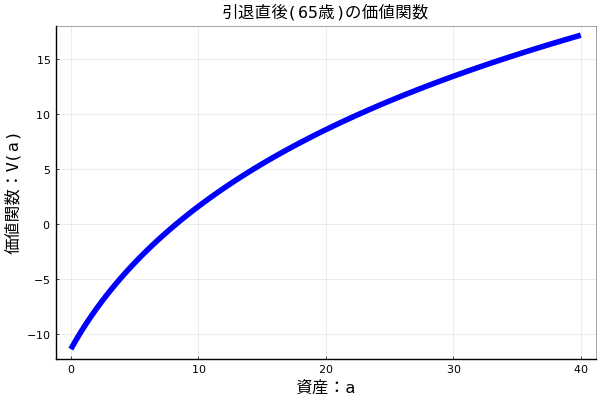

In [23]:
plt = plot(params.agrid, vfcn.old[:, 1],
    color = :blue,
    legend = :none,
    title = ("引退直後(65歳)の価値関数"),
    xlabel = ("資産：a"),
    ylabel = ("価値関数：V(a)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

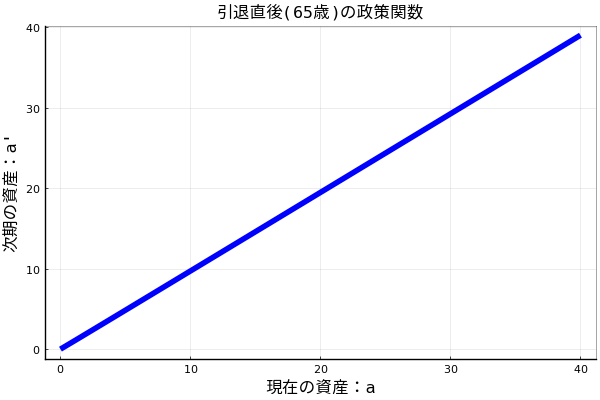

In [24]:
plt = plot(params.agrid, pfcn.old[:, 1],
    color = :blue,
    legend = :none,
    title = ("引退直後(65歳)の政策関数"),
    xlabel = ("現在の資産：a"),
    ylabel = ("次期の資産：a'"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

---

## 若年期の意思決定

In [25]:
"""
若年期のベルマン方程式

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`i::Int64`: 今期の貯蓄(値ではなくインデックス)
`z::Int64`: 今期の労働賦存量(値ではなくインデックス)
`age::Int64`: 年齢
`aprime::Float64`: 次期に残す貯蓄額
`vnext_yng_sp::Vector{Spline1D}`: 次期の若年期の価値関数をスプライン近似した際の係数
`vnext_yng_li::Vector{Spline1D}`: 次期の若年期の価値関数を線形近似した際の係数
`vnext_old::Spline1D`: 次期の老年期の価値関数をスプライン近似した際の係数

### Outputs 
`value::Float64`:　負値にしたベルマン方程式
"""
function bellman_eq_worker(params::Params, i::Int64, z::Int64, age::Int64, aprime::Float64, vnext_yng_sp::Vector{Spline1D}, vnext_yng_li::Vector{Spline1D}, vnext_old::Spline1D)

    # 現在の効用
    wealth = (1+params.r)*params.agrid[i] + params.η[age]*params.endow[z]
    cons = wealth - aprime
    util = MyEconFcn.crra(cons, params.γ)

    # 次期の期待効用
    if age == params.ret_age
        # 引退直前であれば次期にはzの不確実性は存在しないので期待値計算は不要
        vnext = params.surv[age]*params.β*vnext_old(aprime)
    else
        vnext_z = zeros(params.nz)
        # それぞれの次期のzに対応したvalueを計算
        for zz = 1:params.nz
            if aprime <= params.agrid[params.na]
                spl_coef = vnext_yng_sp[zz]
                vnext_z[zz] = spl_coef(aprime)
            else
                li_coef = vnext_yng_li[zz]
                vnext_z[zz] = li_coef(aprime)
            end
        end
        # 遷移確率行列で期待値を計算
        vnext = params.surv[age]*params.β*dot(params.tran[z, :], vnext_z)
    end

    value = util + vnext
    value = -1*value
    return value 
end

bellman_eq_worker

In [26]:
vnext_old = Spline1D(params.agrid, vfcn.old[:, 1], k=3, bc="extrapolate")

Spline1D(knots=[0.0,0.8 … 39.2,40.0] (99 elements), k=3, extrapolation="extrapolate", residual=0.0)

In [27]:
# 価値関数を繰り返し計算
for age = params.ret_age:-1:1

    vnext_yng_sp = Array{Spline1D, 1}(undef, params.nz)
    vnext_yng_li = Array{Spline1D, 1}(undef, params.nz)

    # 次期の価値関数を補間
    if age < params.ret_age
        for z = 1:params.nz
            vnext_yng_sp[z] = Spline1D(params.agrid, vfcn.yng[:, z, age+1], k=3, bc="extrapolate")
            vnext_yng_li[z] = Spline1D(params.agrid, vfcn.yng[:, z, age+1], k=1, bc="extrapolate")
        end
    end

    for i = 1:params.na, z = 1:params.nz
        bellman_eq_worker!(aprime) = bellman_eq_worker(params, i, z, age, aprime, vnext_yng_sp, vnext_yng_li, vnext_old)
        wealth = (1+params.r)*params.agrid[i] + params.η[age]*params.endow[z]
        res = optimize(bellman_eq_worker!, 0.0, wealth, GoldenSection()) # 最適化
        pfcn.yng[i, z, age] = res.minimizer
        vfcn.yng[i, z, age] = -res.minimum
    end

    # println(age)
end

---

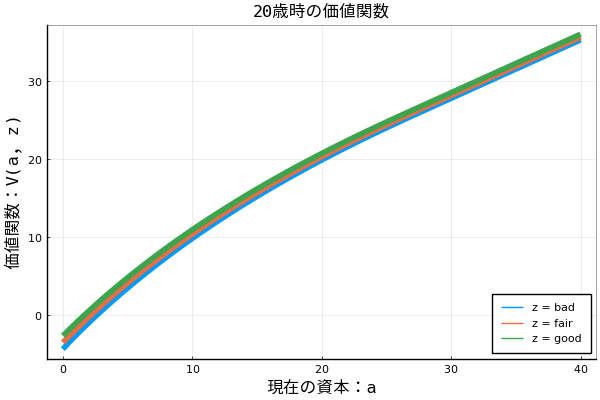

In [28]:
plt = plot(params.agrid, vfcn.yng[:, 1, 1],
    legend = :bottomright,
    title = ("20歳時の価値関数"),
    label = ("z = bad"),
    xlabel = ("現在の資本：a"),
    ylabel = ("価値関数：V(a, z)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.agrid, vfcn.yng[:, 2, 1], linewidth =4, label="z = fair")
plot!(params.agrid, vfcn.yng[:, 3, 1], linewidth =4, label="z = good")

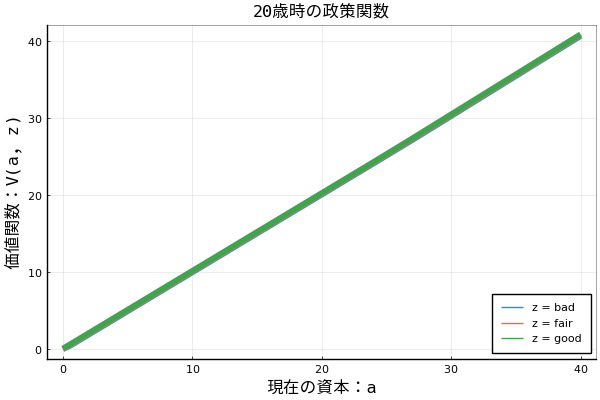

In [29]:
plt = plot(params.agrid, pfcn.yng[:, 1, 1],
    legend = :bottomright,
    title = ("20歳時の政策関数"),
    label = ("z = bad"),
    xlabel = ("現在の資本：a"),
    ylabel = ("価値関数：V(a, z)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.agrid, pfcn.yng[:, 2, 1], linewidth =4, label="z = fair")
plot!(params.agrid, pfcn.yng[:, 3, 1], linewidth =4, label="z = good")

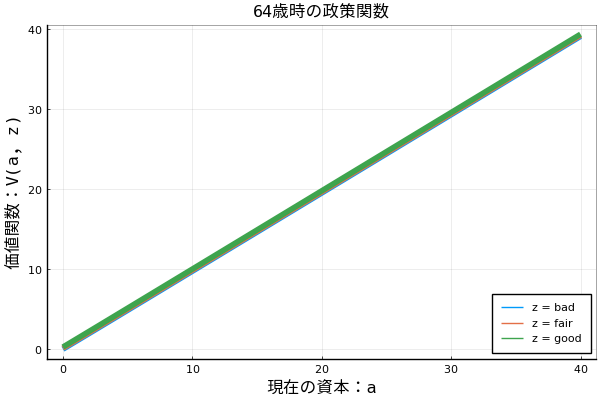

In [30]:
plt = plot(params.agrid, pfcn.yng[:, 1, params.ret_age],
    legend = :bottomright,
    title = ("64歳時の政策関数"),
    label = ("z = bad"),
    xlabel = ("現在の資本：a"),
    ylabel = ("価値関数：V(a, z)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    framestyle = :semi
)
plot!(params.agrid, pfcn.yng[:, 2, params.ret_age], linewidth =4, label="z = fair")
plot!(params.agrid, pfcn.yng[:, 3, params.ret_age], linewidth =4, label="z = good")

---

## シミュレーション
### num_sim人分の乱数を生成
* それぞれret_age期間の所得リスクをシミュレーション
* ここの書き方はもっと効率的にコーディング出来そう

In [31]:
using Random

In [32]:
include("locate.jl")

locate

In [33]:
# シミュレーションをする人数を設定
num_sim = 1000

1000

In [34]:
# 一様分布を生成
uni_rand = rand(params.ret_age, num_sim);

In [35]:
seq_endow = zeros(Int64, params.ret_age, num_sim);

#### zの初期分布は一様分布を仮定
* good, fair, badがそれぞれ1/3ずつ存在

In [36]:
z_ini_cdf = zeros(params.nz+1)
for i = 1:params.nz
    z_ini_cdf[i+1] = z_ini_cdf[i] + 1/params.nz
end

In [37]:
for j = 1:num_sim
   seq_endow[1, j] = locate(z_ini_cdf, uni_rand[1, j]) 
end

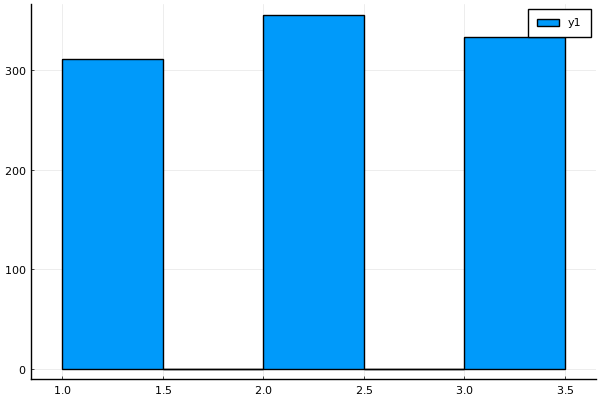

In [38]:
# good、fair、badが一様分布していることを確認
histogram(seq_endow[1, :])

In [39]:
# 遷移確率行列からzの累積密度分布を計算
z_cdf = zeros(params.nz, params.nz+1)
for i = 1:params.nz
    for j = 1:params.nz
        z_cdf[i, j+1] = z_cdf[i, j] + params.tran[i, j]
    end
end

In [40]:
# ret_age-1期間のシミュレーション
for j = 1:num_sim
    for i = 2:params.ret_age
        seq_endow[i, j] = locate(z_cdf[seq_endow[i-1, j], :], uni_rand[i, j])
    end
end

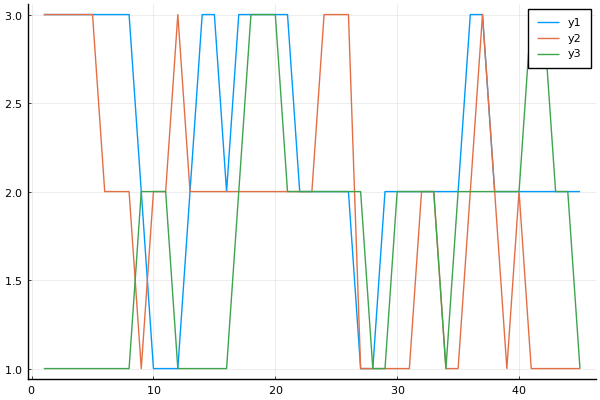

In [41]:
# 3人分の46期間の動きを確認
plot(seq_endow[:, 1])
plot!(seq_endow[:, 2])
plot!(seq_endow[:, 3])

---

### 政策関数を使って前向きに解いていく

In [42]:
a_sim = zeros(params.max_age, num_sim)
y_sim = zeros(params.ret_age, num_sim)
c_sim = zeros(params.max_age, num_sim);

In [43]:
# 計算した政策関数を使ってシミュレーション
for j = 1:num_sim
    # 労働者
    for age = 1:params.ret_age
        y_sim[age, j] = η[age]*params.endow[seq_endow[age, j]]
        wealth = (1+params.r)*a_sim[age, j] + y_sim[age, j]
        # 資産が大きすぎて定義域の外まで増えた場合、スプラインではなく線形近似を使う
        # そもそもグリッドを調整すべき問題なので定義域の外に行かないようにモデルのパラメータを設定
        if a_sim[age, j] <= params.agrid[params.na]
            # スプライン補間
            interp_coef = Spline1D(params.agrid, pfcn.yng[:, seq_endow[age, j], age], k=3, bc="extrapolate")
        else
            # 線形補間
            interp_coef = Spline1D(params.agrid, pfcn.yng[:, seq_endow[age, j], age], k=1, bc="extrapolate")
        end
        a_sim[age+1, j] = interp_coef(a_sim[age, j])
        c_sim[age, j] = wealth - a_sim[age+1, j]
    end
    # 引退
    for age = params.ret_age+1:params.max_age
        i = age - params.ret_age
        wealth = (1+params.r)*a_sim[age, j] + params.ss
        if a_sim[age, j] <= params.agrid[params.na]
            interp_coef = Spline1D(params.agrid, pfcn.old[:, i], k=3, bc="extrapolate")
        else
            interp_coef = Spline1D(params.agrid, pfcn.old[:, i], k=1, bc="extrapolate")
        end
        if age < params.max_age
            a_sim[age+1, j] = interp_coef(a_sim[age, j])
            c_sim[age, j] = wealth - a_sim[age+1, j]
        elseif age == params.max_age
            c_sim[age, j] = wealth
        end
    end
end

### 平均プロファイルを計算

In [44]:
a_prof = zeros(params.max_age)
c_prof = zeros(params.max_age);

In [45]:
# 年齢ごとの平均値
for age = 1:params.max_age
    a_prof[age] = sum(a_sim[age, :]) / num_sim
    c_prof[age] = sum(c_sim[age, :]) / num_sim
end

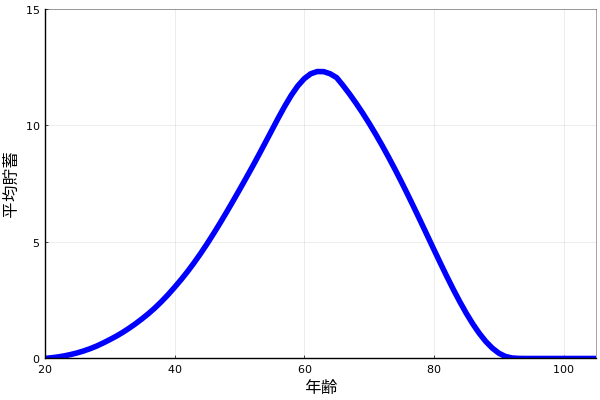

In [46]:
age = 20:105

plt = plot(age, a_prof,
    color = :blue,
    legend = :none,
#    title = ("年齢ごとの平均貯蓄額"),
    xlims = (20, 105),
    ylims = (0, 15.0),
    label = ("1"),
    xlabel = ("年齢"),
    ylabel = ("平均貯蓄"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
#savefig(plt, "Fig3_asset_profile.eps")

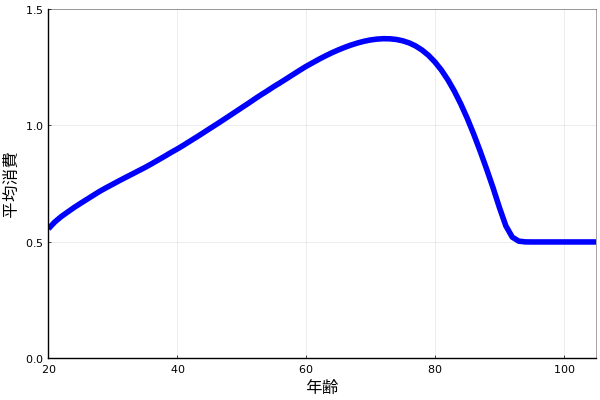

In [47]:
age = 20:105

plt = plot(age, c_prof,
    color = :blue,
    legend = :none,
#    title = ("年齢ごとの平均消費"),
    xlims = (20, 105),
    ylims = (0, 1.5),
    label = ("1"),
    xlabel = ("年齢"),
    ylabel = ("平均消費"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
#savefig(plt, "Fig3_consumption_profile.eps")

---

## シミュレーション結果をプロット

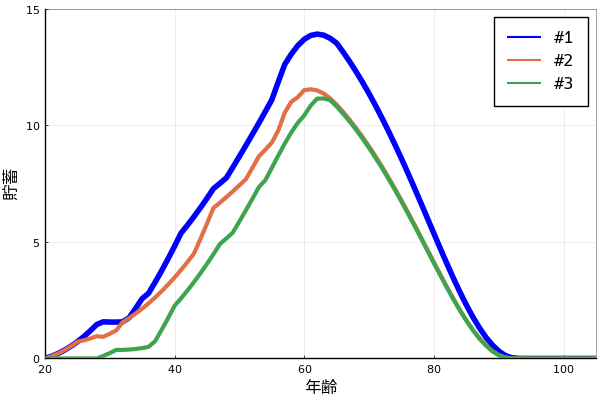

In [48]:
age = 20:105

plt = plot(age, a_sim[:, 1],
    color = :blue,
    legend = :topright,
    xlims = (20, 105),
    ylims = (0, 15.0),
    label = ("#1"),
    xlabel = ("年齢"),
    ylabel = ("貯蓄"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(age, a_sim[:, 2], linewidth = 3, label="#2")
plot!(age, a_sim[:, 3], linewidth = 3, label="#3")

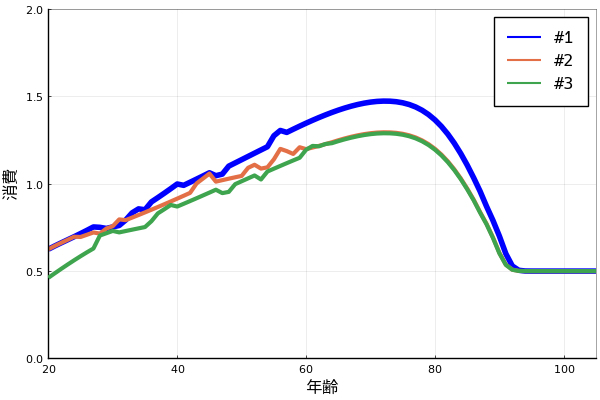

In [49]:
age = 20:105

plt = plot(age, c_sim[:, 1],
    color = :blue,
    legend = :topright,
    xlims = (20, 105),
    ylims = (0, 2.0),
    label = ("#1"),
    xlabel = ("年齢"),
    ylabel = ("消費"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(age, c_sim[:, 2], linewidth = 3, label="#2")
plot!(age, c_sim[:, 3], linewidth = 3, label="#3")

---

## エクササイズ
* 価値関数の近似で定義域の外を線形補間で外挿しているが、これを3次のスプライン近似あるいは別の方法に切り替えた場合に何が起こるかを確認してみよう。

In [50]:
out = open("asset_profile.csv", "w")
for age = 1:params.max_age
    println(out, a_prof[age])
end
close(out)

In [51]:
out = open("consumption_profile.csv", "w")
for age = 1:params.max_age
    println(out, c_prof[age])
end
close(out)